In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
NUM_IMAGES_TRAIN = 13000*21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import os


# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

motion_transform_train = transforms.Compose([
                                    # transforms.Resize((256, 256)),
                                    # transforms.RandomHorizontalFlip(),
                                    # transforms.ColorJitter(hue=.2, saturation=.2, contrast=.2),
                                    # transforms.RandomRotation(20, interpolation=Image.BILINEAR),
                                    # transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    normalize,
                                ])

class CompDataset(Dataset):
    def __init__(self, data_dir, size=NUM_IMAGES_TRAIN, motion_transform=motion_transform_train, content_transform=None):
        self.data_dir = data_dir
        self.motion_transform = motion_transform
        self.content_transform = content_transform
        self.size = size
        self.frame_list = []

        self.count = 0
        for vid_dir in os.listdir(self.data_dir):
            for i in range(21):
                self.frame_list.append(self.data_dir+"/"+vid_dir+"/image_"+str(i)+".png")
                self.count +=1

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        image1 = read_image(self.frame_list[idx])
        image2 = read_image(self.frame_list[idx+1])
        label = -1
        
        
        par_dir = os.path.dirname(self.frame_list[idx])
        if os.path.isfile(par_dir+"/mask.npy"):
            try:
                label = read_image(par_dir+"/mask.npy")
            except:
                return None, None, None
        
        image1= image1/255.0
        image2 = image2/255.0

        if self.motion_transform:
            image1 = self.motion_transform(image1)
            image2 = self.motion_transform(image2)

        return image1, image2, label

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)



unlabeled_data = CompDataset("/dataset/dataset/unlabeled")
train_dataloader = DataLoader(unlabeled_data, batch_size=1, shuffle=True, collate_fn = collate_fn)

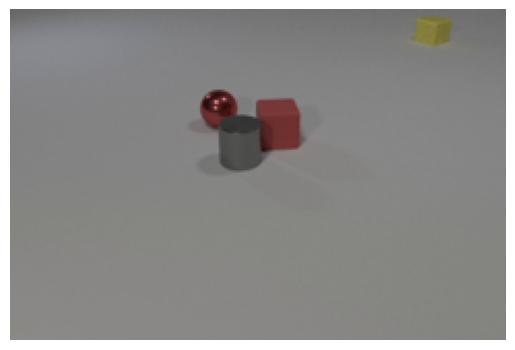

In [4]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0).numpy())
    plt.title(title)
    plt.axis('off')

show_normalized_image(unlabeled_data[10][0])

In [5]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    if not torch.is_tensor(flo): 
        return x
    B, C, H, W = x.size()
    # mesh grid 
    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float().to(device)
    print(x.shape)
    print(torch.autograd.Variable(grid).shape, flo.shape)
    
    vgrid = torch.autograd.Variable(grid) + flo

    # scale grid to [-1,1] 
    vgrid[:,0,:,:] = 2.0*vgrid[:,0,:,:].clone() / max(W-1,1)-1.0
    vgrid[:,1,:,:] = 2.0*vgrid[:,1,:,:].clone() / max(H-1,1)-1.0

    vgrid = vgrid.permute(0,2,3,1)        
    output = nn.functional.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).to(device)
    mask = nn.functional.grid_sample(mask, vgrid)

    # if W==128:
      # np.save('mask.npy', mask.cpu().data.numpy())
      # np.save('warp.npy', output.cpu().data.numpy())

    mask[mask<0.9999] = 0
    mask[mask>0] = 1

    return output*mask

In [6]:
class FEA(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(2)

    def forward(self, X_tnext, X_hat_tnext, f_tprev_t):
        correlation = self.corr4D(X_tnext, X_hat_tnext)
        batch_size, out_channels, ht, wd = X_tnext.shape
        mat_mul = correlation @ X_tnext.view(batch_size, out_channels, ht*wd, 1)
        mat_mul = mat_mul.view(batch_size, out_channels, ht, wd)
        x = self.maxPool(self.relu(self.bn(self.cnn(mat_mul))))
        x = self.upsample(x)
        x += f_tprev_t
        return x

    def corr4D(self, X_tnext, X_hat_tnext):
        batch, dim, ht, wd = X_tnext.shape
        X_tnext = X_tnext.view(batch, dim, ht*wd)
        X_hat_tnext = X_hat_tnext.view(batch, dim, ht*wd) 

        corr = torch.matmul(X_tnext.transpose(1,2), X_hat_tnext)
        corr = corr.view(batch, 1, ht*wd, ht*wd)
        return corr/torch.sqrt(torch.tensor(dim).float())

    def upsample(self, flow, mode='bilinear'):
        new_size = (2 * flow.shape[2], 2 * flow.shape[3])
        return  2 * F.interpolate(flow, size=new_size, mode=mode, align_corners=True)

In [7]:
class Encoder(nn.Module):
    def __init__ (self, in_features, out_features):
        super().__init__()
        self.cnn = nn.Conv2d(in_features, out_features, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.bn = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU()
        self.maxPool = nn.MaxPool2d(2)

    def forward(self, I):
        return self.maxPool(self.relu (self.bn(self.cnn(I))))

In [8]:
class MCJepa(nn.Module):
    def __init__(self, numLayers, in_features, out_features, out_features_fea):
        super().__init__()
        self.numLayers = numLayers;
        self.enc1 = nn.ModuleList([Encoder(in_features, out_features) for i in range(numLayers)])
        # self.enc2 = [Encoder(in_features, out_features) for i in range(numLayers)]
        self.fea = nn.ModuleList([FEA(out_features, out_features_fea) for i in range(numLayers)])
        self.f_tprev_t = 0 # TODO: this has to be a tensor
        self.f_tnext_t = 0 # TODO: this has to be a tensor

    def forward(self, I_t, I_tnext):
        X_hat_tnext = []
        X_hat_t = []
        X_t = []
        X_tnext = []
        f_t_tnext = []
        f_tnext_t = []

        for i in range(self.numLayers): # Feature extracting layer
            X_t.append(self.enc1[i](I_t))
            X_tnext.append(self.enc1[i](I_tnext))

        for i in range(self.numLayers): # Finding the flow t -> t + 1
            if i == 0:
                f_t_tnext.append(self.fea[i](X_tnext[i], X_t[0], self.f_tprev_t))
            else:
                X_hat_tnext.append(warp(X_t[i], f_t_tnext[i-1]))
                f_t_tnext.append(self.fea[i](X_tnext[i], X_hat_tnext[i-1], f_t_tnext[i-1]))

        self.f_tprev_t = f_t_tnext[-1] # Remembering the flow info across frames

        I_hat_tnext = warp(I_t, f_t_tnext[-1]) # Predicting future frame

        for i in range(self.numLayers): # Finding the flow t + 1 -> t
            if i == 0:
                f_tnext_t.append(self.fea[i](X_t[i], X_tnext[0], self.f_tnext_t))
            else:
                X_hat_t.append(warp(X_tnext[i], f_tnext_t[i-1]))
                f_tnext_t.append(self.fea[i](X_t[i], X_hat_t[i-1], f_tnext_t[i-1]))

        self.f_tnext_t = f_tnext_t[-1] # Remembering the flow info across backward frames

        I_hat_t = warp(I_tnext, f_tnext_t[-1]) # Predicting past frame

        return {X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext}


In [9]:
# Constants to figure out later
numLayers = 10
in_features = 3 
out_features = 16
out_features_fea = 2
lm, mu, nu, lambda_a, lambda_b = 2, 2, 1, 10, 10

model = MCJepa(numLayers, in_features, out_features, out_features_fea).to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.0001)


In [10]:
def off_diagonal(M):
    res = M.clone()
    res.diagonal(dim1=-1, dim2=-2).zero_()
    return res

def vc_reg(X_t, X_tnext, lm, mu, nu):
    N = X_t.size[0]
    D = X_t.size[1] + X_t.size[2] + X_t.size[3] 
    sim_loss = nn.MSELoss(X_t, X_tnext)

    std_z_a = F.sqrt(X_t.var(dim=0) + 1e-04)
    std_z_b = F.sqrt(X_tnext.var(dim=0) + 1e-04)
    std_loss = F.mean(F.relu(1-std_z_a)) + F.mean(F.relu(1-std_z_b))

    X_t = X_t - X_t.mean(dim=0)
    X_tnext = X_tnext - X_tnext.mean(dim=0)
    cov_z_a = (X_t.T @ X_t) / (N-1)
    cov_z_b = (X_tnext.T @ X_tnext) / (N-1)
    conv_loss = (off_diagonal(cov_z_a).pow_(2).sum()/D) + (off_diagonal(cov_z_b).pow_(2).sum()/D) 

    loss = lm*sim_loss + mu*std_loss + nu*conv_loss
    return loss

def cycle_loss(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b):
    loss_cycle_A = [F.l1_loss(warp(X_t[i], f_t_tnext[i]), X_tnext[i]) * lambda_a for i in range(1, len(X_t))]
    loss_cycle_B = [F.l1_loss(warp(X_tnext[i], f_tnext_t[i]), X_t[i]) * lambda_b for i in range(1, len(X_tnext))]

    return loss_cycle_A + loss_cycle_B

In [11]:
def criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, img1, img2, lm, mu, nu, lambda_a, lambda_b, label):
  
    regress_loss_forward = [nn.MSELoss(X_hat_tnext[i], X_tnext[i]) for i in range(len(X_hat_tnext)) ]
    regress_loss_backward = [nn.MSELoss(X_hat_t[i], X_t[i]) for i in range(len(X_hat_t)) ]
    reconst_loss_forward = nn.MSELoss(I_hat_tnext, img2) 
    reconst_loss_backward = nn.MSELoss(I_hat_t, img1)
    vc_reg_loss = [vc_reg(X_t[i], X_tnext[i], lm, mu, nu) for i in range(len(X_t))]
    cycle_loss = cycle_loss(f_t_tnext, f_tnext_t, X_t, X_tnext, lambda_a, lambda_b)

    return sum(regress_loss_forward) + sum(regress_loss_backward) + reconst_loss_forward + reconst_loss_backward + sum(vc_reg_loss) + sum(cycle_loss)



In [12]:
from tqdm import tqdm

def train_model(model, epochs, dataloader, criterion, optimizer):
    model.train()

    pbar = tqdm(range(epochs))

    train_losses = []

    for i in pbar:
        total_train_loss = 0.0
        total_train_correct = 0.0

        model.train()

        for batch in tqdm(dataloader, leave=False):
            img1 = batch[0].to(device)
            img2 = batch[1].to(device)
            label = batch[2].to(device)

            X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext = model(img1, img2)

            loss = criterion(X_t, X_tnext, X_hat_t, X_hat_tnext, f_t_tnext, f_tnext_t, I_hat_t, I_hat_tnext, lm, mu, nu, lambda_a, lambda_b, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()/len(label)

    train_losses.append(total_train_loss/len(dataloader))

    pbar.set_postfix({'train_loss': train_losses[-1]})

In [13]:
train_model(model, 1, train_dataloader, criterion, optimizer)

  0%|          | 0/273000 [00:00<?, ?it/s]

torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 16, 80, 120])
torch.Size([1, 2, 80, 120]) torch.Size([1, 2, 80, 120])
torch.Size([1, 3, 160, 240])
torch.Size([1, 2, 160, 240]) torch.Size([1, 2, 80, 120])


/home/sd5313/.local/lib/python3.10/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(

  0%|          | 0/1 [00:10<?, ?it/s]     


RuntimeError: The size of tensor a (240) must match the size of tensor b (120) at non-singleton dimension 3